This notebook calculates the classification accuracy with genes involved in peptidergic communication.

We perform classification at two levels of cell type annotations: `class` and `subclass`.

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cci.graph import get_available_lr
from cci.utils import get_adata, rand_predict, gene_label_prediction_classification_report

from sklearn.metrics import confusion_matrix
from cci.utils import get_adata

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina'

In [35]:
# Fetch merfish data from only VISp.
# Full set of cells that are part of the VISp region
adata_VISp = get_adata("VISp")

# 2 lists below contain classes and subclasses containing neuronal cells
# Classes and subclasses whose cell count is less than 1% of total cells in the VISp region have been excluded
classes_to_keep_VISp = ["01 IT-ET Glut", "02 NP-CT-L6b Glut", "06 CTX-CGE GABA", "07 CTX-MGE GABA"]

subclasses_to_keep_VISp = [
    "006 L4/5 IT CTX Glut",
    "007 L2/3 IT CTX Glut",
    "030 L6 CT CTX Glut",
    "004 L6 IT CTX Glut",
    "022 L5 ET CTX Glut",
    "052 Pvalb Gaba",
    "005 L5 IT CTX Glut",
    "053 Sst Gaba",
    "032 L5 NP CTX Glut",
    "046 Vip Gaba",
    "049 Lamp5 Gaba",
]


/allen/programs/celltypes/workgroups/mousecelltypes/Donghyun/envs/miniconda3/envs/pyg/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [36]:
def display_label(adata):
    df_1 = adata.obs[["class"]].value_counts().to_frame().sort_values(by="class").reset_index()
    df_1 = df_1.rename(columns = {"count":"class_count"})

    df_2 = adata.obs[["class", "subclass"]].value_counts().to_frame().sort_values(by="class").reset_index()
    df_2 = df_2.rename(columns = {"count":"subclass_count"})

    df = df_2.merge(df_1, how="left", left_on="class", right_on="class")
    df = df.sort_values(['class_count', 'subclass_count'], ascending=[False, False]).reset_index(drop=True)

    return df

In [37]:
# Subsetting the full set of cells to only include classes and subclasses shown in 2 lists above

# Distribution of dataset after subsetting
print("Before subsetting")
#display_label(adata_VISp)

# use pandas styler to highlight the rows that will be removed with a light red background color
# using Styler.map_index
df = display_label(adata_VISp)
df.style.apply(lambda x: ['background: lightcoral' if x.name not in classes_to_keep_VISp and x.name not in subclasses_to_keep_VISp else '' for i in x], axis=1)
display(df)


Before subsetting


,class,subclass,subclass_count,class_count
0,01 IT-ET Glut,006 L4/5 IT CTX Glut,16551,34168
1,01 IT-ET Glut,007 L2/3 IT CTX Glut,9865,34168
2,01 IT-ET Glut,004 L6 IT CTX Glut,3136,34168
3,01 IT-ET Glut,022 L5 ET CTX Glut,2531,34168
4,01 IT-ET Glut,005 L5 IT CTX Glut,1921,34168
5,01 IT-ET Glut,001 CLA-EPd-CTX Car3 Glut,111,34168
6,01 IT-ET Glut,003 L5/6 IT TPE-ENT Glut,28,34168
7,01 IT-ET Glut,002 IT EP-CLA Glut,22,34168
8,01 IT-ET Glut,015 ENTmv-PA-COAp Glut,1,34168
9,01 IT-ET Glut,018 L2 IT PPP-APr Glut,1,34168


In [38]:
print("After subsetting to only include classes listed above")

adata_VISp_neuronal = adata_VISp[adata_VISp.obs['class'].isin(classes_to_keep_VISp)]

display_label(adata_VISp_neuronal)

After subsetting to only include classes listed above


,class,subclass,subclass_count,class_count
0,01 IT-ET Glut,006 L4/5 IT CTX Glut,16551,34168
1,01 IT-ET Glut,007 L2/3 IT CTX Glut,9865,34168
2,01 IT-ET Glut,004 L6 IT CTX Glut,3136,34168
3,01 IT-ET Glut,022 L5 ET CTX Glut,2531,34168
4,01 IT-ET Glut,005 L5 IT CTX Glut,1921,34168
5,01 IT-ET Glut,001 CLA-EPd-CTX Car3 Glut,111,34168
6,01 IT-ET Glut,003 L5/6 IT TPE-ENT Glut,28,34168
7,01 IT-ET Glut,002 IT EP-CLA Glut,22,34168
8,01 IT-ET Glut,018 L2 IT PPP-APr Glut,1,34168
9,01 IT-ET Glut,021 L4 RSP-ACA Glut,1,34168


In [39]:
print("After subsetting to only include classes and subclasses listed above")

adata_VISp_neuronal = adata_VISp_neuronal[adata_VISp_neuronal.obs['subclass'].isin(subclasses_to_keep_VISp)]

display_label(adata_VISp_neuronal)

After subsetting to only include classes and subclasses listed above


,class,subclass,subclass_count,class_count
0,01 IT-ET Glut,006 L4/5 IT CTX Glut,16551,34004
1,01 IT-ET Glut,007 L2/3 IT CTX Glut,9865,34004
2,01 IT-ET Glut,004 L6 IT CTX Glut,3136,34004
3,01 IT-ET Glut,022 L5 ET CTX Glut,2531,34004
4,01 IT-ET Glut,005 L5 IT CTX Glut,1921,34004
5,02 NP-CT-L6b Glut,030 L6 CT CTX Glut,7506,8345
6,02 NP-CT-L6b Glut,032 L5 NP CTX Glut,839,8345
7,07 CTX-MGE GABA,052 Pvalb Gaba,2113,3571
8,07 CTX-MGE GABA,053 Sst Gaba,1458,3571
9,06 CTX-CGE GABA,046 Vip Gaba,713,1287


In [40]:
# full list of ligands and receptors as per Smith et al. 2019
ligands = [['Npy'],[ 'Sst'], ['Vip'], ['Tac2'], ['Cck'], ['Penk'], ['Crh'], ['Cort'], ['Tac1'], ['Pdyn'], ['Pthlh'], ['Pnoc'], ['Trh'], ['Grp'], ['Rln1'], ['Adcyap1'], ['Nts'], ['Nmb']]
receptors = [["Npy1r", "Npy2r", "Npy5"], ["Sstr1", "Sstr2", "Sstr3", "Sstr4" ], ["Vipr1", "Vipr2"], ["Tacr3"], ["Cckbr"], ["Oprd1", "Oprm1"], ["Crhr1", "Crhr2"], ["Sstr1", "Sstr2", "Sstr3", "Sstr4"], ["Tacr1"], ["Oprd1", "Oprk1", "Oprm1"], ["Pth1r"], ["Oprl1"], ["Trhr", "Trhr2"], ["Grpr"], ["Rxfp1", "Rxfp2", "Rxfp3"], ["Adcyap1r1", "Vipr1", "Vipr2"], ["Ntsr1", "Ntsr2"], ["Nmbr"]]

ligand_index, receptor_index = get_available_lr(adata_VISp_neuronal) 
# returns a dictionary containing ligand and receptor genes available in dataset
# dictionary key is an index corresponding to the ligand-receptor pair
for i in range(len(ligands)):
    if i in ligand_index and i in receptor_index: # both ligand and receptor corresponding to a pair exists
        adjs = []
        for ligand in ligand_index[i]:
            for receptor in receptor_index[i]:
                print(ligand, receptor) # Ligand and receptor pairs that exist in the dataset 

Tac2 Tacr3
Penk Oprd1
Pdyn Oprd1
Pdyn Oprk1
Grp Grpr


#### Class classification on VISp dataset

In [42]:
# List of all genes from the 4 LR communication pairs found above
lr_genes_combined = ["Tac2", "Tacr3", 'Penk', 'Oprd1', "Pdyn", "Oprd1", "Oprk1", "Grp", "Grpr"]
#Predicting cell class with gene expression of the above list of cells. Logistic Regression with cross validation is used for prediction.
all_lr_class, y_test_class, y_pred_test_class = gene_label_prediction_classification_report(adata_VISp_neuronal, lr_genes_combined, "class", random_state = 42)

# Classification report showing per class metrics for prediction with genes from all 4 LR communication pairs
display(all_lr_class)

Train Accuracy: 0.809 | Test Accuracy: 0.814


,precision,recall,f1-score,support
weighted avg,0.81,0.81,0.79,1.00
macro avg,0.84,0.62,0.68,1.00
01 IT-ET Glut,0.82,0.96,0.88,0.72
02 NP-CT-L6b Glut,0.72,0.30,0.43,0.18
07 CTX-MGE GABA,0.87,0.75,0.81,0.08
06 CTX-CGE GABA,0.94,0.45,0.61,0.03
accuracy,0.81,0.81,0.81,0.00


#### Subclass classification on VISp dataset

In [43]:
#Predicting cell subclass with gene expression of the above list of cells. 
all_lr_subclass, y_test_subclass, y_pred_test_subclass = gene_label_prediction_classification_report(adata_VISp_neuronal, lr_genes_combined, "subclass", random_state = 42)

Train Accuracy: 0.522 | Test Accuracy: 0.528


In [10]:
# Classification report showing per subclass metrics for prediction with genes from all 4 LR communication pairs
all_lr_subclass

,precision,recall,f1-score,support
macro avg,0.411645,0.359110,0.359997,1.000000
weighted avg,0.470538,0.527642,0.472898,1.000000
006 L4/5 IT CTX Glut,0.522047,0.832147,0.641591,0.357128
007 L2/3 IT CTX Glut,0.476217,0.423251,0.448175,0.210443
030 L6 CT CTX Glut,0.490081,0.450980,0.469718,0.156641
004 L6 IT CTX Glut,0.358209,0.041096,0.073733,0.061851
022 L5 ET CTX Glut,0.241379,0.028866,0.051565,0.051366
052 Pvalb Gaba,0.719078,0.801402,0.758011,0.045329
005 L5 IT CTX Glut,0.000000,0.000000,0.000000,0.039293
053 Sst Gaba,0.809524,0.534965,0.644211,0.030290


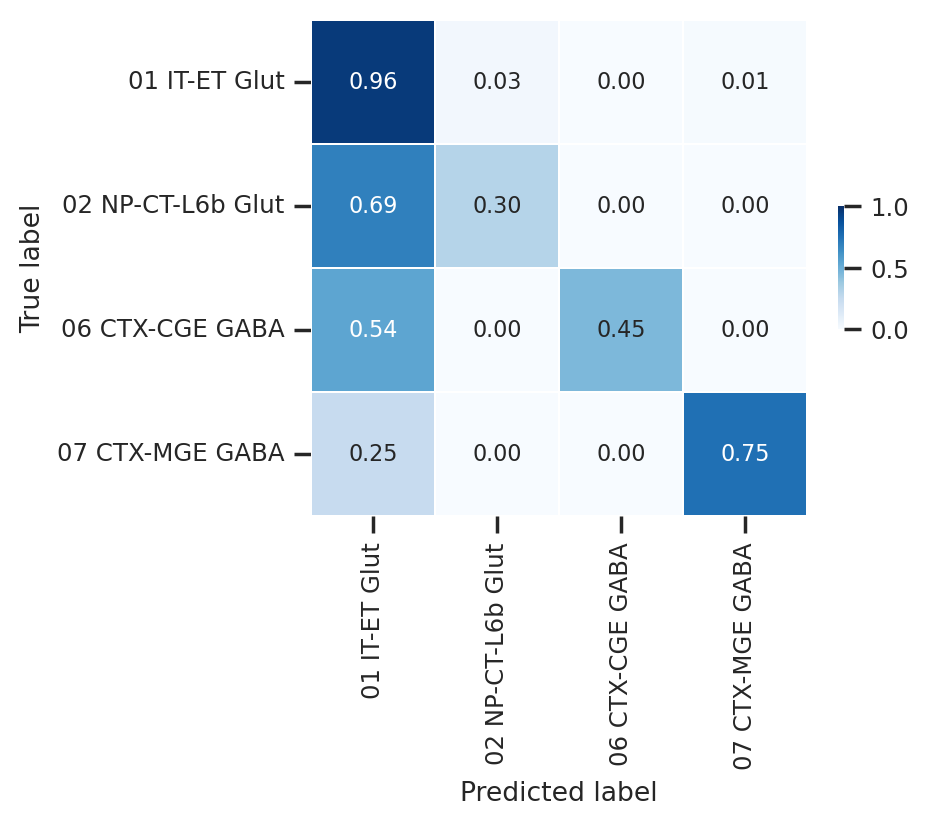

In [15]:

def conf_matrix_plot(adata, y_test, y_pred_test):
    cell_type_list = np.unique(y_test)
    matrix = confusion_matrix(y_test, y_pred_test, labels = cell_type_list)

    matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]
    df = pd.DataFrame(matrix, index=cell_type_list[:matrix.shape[0]], columns=cell_type_list[:matrix.shape[1]])
    f, ax = plt.subplots(1,1, figsize=(4, 4))
    sns.heatmap(df, cmap='Blues', annot=True ,fmt=".2f", 
                annot_kws={'size': 8}, 
                vmin=0, vmax=1, ax=ax, 
                linewidths=0.1, 
                square=True,
                cbar_kws={'shrink': .2}, 
                xticklabels=1, 
                yticklabels=1)
    ax.set(xlabel='Predicted label', ylabel='True label')    
    plt.show()

conf_matrix_plot(adata_VISp_neuronal, y_test_class, y_pred_test_class)

In [12]:
# Using a dummy classifier to randomly predict cell class. 3 strategies are used.
rand = rand_predict("subclass", pd.DataFrame(adata_VISp_neuronal[:,lr_genes_combined].X.todense()), adata_VISp_neuronal)
rand

{'prior': 0.34685447998305446,
 'stratified': 0.20355856809997883,
 'uniform': 0.09150603685659818}

In [13]:
# List of genes from the each of the 4 LR communication pairs found above
lr_genelist = [ ["Tac2", "Tacr3"], ['Penk', 'Oprd1'], ["Pdyn", "Oprd1", "Oprk1"], ["Grp", "Grpr"]]

#Predicting cell class with gene expression using each of the 4 sets of genes. 

lr0, _, _ = gene_label_prediction_classification_report(adata_VISp_neuronal, lr_genelist[0], "class", random_state = 42)
lr1, _, _ = gene_label_prediction_classification_report(adata_VISp_neuronal, lr_genelist[1], "class", random_state = 42)
lr2, _, _ = gene_label_prediction_classification_report(adata_VISp_neuronal, lr_genelist[2], "class", random_state = 42)
lr3, _, _ = gene_label_prediction_classification_report(adata_VISp_neuronal, lr_genelist[3], "class", random_state = 42)

Train Accuracy: 0.726 | Test Accuracy: 0.726
Train Accuracy: 0.768 | Test Accuracy: 0.768
Train Accuracy: 0.767 | Test Accuracy: 0.766
Train Accuracy: 0.745 | Test Accuracy: 0.749


In [14]:
# Classification report showing per subclass metrics for prediction with genes from the second LR pair
lr1

,precision,recall,f1-score,support
macro avg,0.604732,0.455789,0.463771,1.000000
weighted avg,0.635653,0.767952,0.684075,1.000000
01 IT-ET Glut,0.762695,0.987498,0.860659,0.720080
02 NP-CT-L6b Glut,0.000000,0.000000,0.000000,0.176340
07 CTX-MGE GABA,0.842282,0.703081,0.766412,0.075620
06 CTX-CGE GABA,0.813953,0.132576,0.228013,0.027960
accuracy,0.767952,0.767952,0.767952,0.000081
